# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

# Setup

In [1]:
import numpy as np
import pprint
from typing import Literal, List
from json import loads, dumps

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

import pandas as pd

In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-2")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['FHE-resnet18-qnn-14385582', 'Standard-resnet18-14385579', 'FHE-resnet18-qnn-14096301', 'FHE-resnet18-qcnn-14621587', 'Standard-fednn-14096292', 'FHE-fednn-14378195', 'Standard-fednn-14288051', 'FHE-fednn-14385574', 'Standard-qcnn-14096296', 'Standard-fedqnn-14166516', 'FHE-resnet18-qnn-14288060', 'FHE-qcnn-14378199', 'Standard-resnet18-qcnn-14378204', 'Standard-fedqnn-14385575', 'FHE-fedqnn-14385576', 'Standard-qcnn-14166518', 'Standard-qcnn-14288055', 'FHE-resnet18-qcnn-14616215', 'Standard-resnet18-14166520', 'Standard-fednn-14385573', 'Standard-resnet18-qnn-14166522', 'FHE-qcnn-14096297', 'FHE-resnet18-14288058', 'FHE-resnet18-14166521', 'Standard-qcnn-14378198', 'Standard-resnet18-14288057', 'Standard-resnet18-qcnn-14385583', 'FHE-fednn-14166515', 'Standard-resnet18-qnn-14096300', 'FHE-resnet18-14096299', 'FHE-fednn-14288052', 'Standard-resnet18-qcnn-14096302', 'Standard-resnet18-14378200', 'FHE-resnet18-qcnn-14602070', 'FHE-fednn-14096293', 'FHE-fedqnn-14166517', 'FHE-resnet18-q

# EDA

In [4]:
group_in_focus = groups[0]

In [5]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: ugmoh5p2, Name: server, Type: server
Run ID: 166vcvla, Name: client16, Type: client16
Run ID: 2rthcsnl, Name: client3, Type: client3
Run ID: alkq4ybg, Name: client8, Type: client8
Run ID: b7gcmr3r, Name: client6, Type: client6
Run ID: d5bkpp0t, Name: client12, Type: client12
Run ID: dsmtxpp0, Name: client14, Type: client14
Run ID: epxiwect, Name: client0, Type: client0
Run ID: evwpz80i, Name: client7, Type: client7
Run ID: g4c9n8ok, Name: client4, Type: client4
Run ID: i37krjwg, Name: client18, Type: client18
Run ID: lnoyhh9i, Name: client1, Type: client1
Run ID: mkbzfhx4, Name: client11, Type: client11
Run ID: mra9fbnk, Name: client9, Type: client9
Run ID: p8i5sd13, Name: client2, Type: client2
Run ID: qj5aoq2z, Name: client10, Type: client10
Run ID: r5b5qize, Name: client19, Type: client19
Run ID: rzjvo9s3, Name: client13, Type: client13
Run ID: slc3k7k2, Name: client17, Type: client17
Run ID: q2w8vwgp, Name: client15, Type: client15
Run ID: aw663gga, Name: client5, Type: cli

## Settings

In [6]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': True,
 'group': 'FHE-resnet18-qnn-14385582',
 'learning_rate': '1e-3',
 'model': 'resnet18-qnn',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [7]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [8]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                            Server Statistics (Part 1)                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃            Mean ┃          Median ┃            Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ _timestamp                 │   1748289632.86 │   1748289700.37 │        9281.70 │
│ trainable_parameters       │         2096.00 │         2096.00 │            nan │
│ _step                      │           10.50 │           10.50 │           6.49 │
│ Total Bytes Received       │ 147135309445.55 │ 147135308730.00 │ 82901399347.42 │
│ _runtime                   │        15227.17 │        15294.68 │        9281.71 │
│ Total Bytes Sent           │   2612545118.50 │   2612545118.50 │  1626944344.55 │
│ parameter_aggregation_time │           60.16 │           59.90 │           1.71 │
│ Bytes Received (Round)     │  14012890861.30 │  14012883737.00 │       42127.04 │
│ Bytes Sent (Round)         │    261254054.75 │    275003787.00 │    61490671.97 │
│ round_time                 │         1365.81 │         1361.27 │          12.09 │
│ metrics_agg.f1s            │            0.29 │            0.32 │           0.12 │
│ metrics_agg.recalls        │            0.29 │            0.32 │           0.12 │
│ total_training_time        │        29010.45 │        29010.45 │            nan │
│ metrics_agg.precisions     │            0.29 │            0.32 │           0.12 │
│ loss_agg                   │            1.48 │            1.38 │           0.33 │
│ metrics_agg.accuracy       │           29.01 │           32.25 │          11.84 │
│ round                      │           10.50 │           10.50 │           5.92 │
└────────────────────────────┴─────────────────┴─────────────────┴────────────────┘

                                            Server Statistics (Part 2)                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃            25% ┃             75% ┃             Max ┃            Min ┃            Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ _timestamp              │  1748282139.78 │   1748297288.57 │   1748303419.45 │  1748274408.97 │   1748303419.45 │
│ trainable_parameters    │        2096.00 │         2096.00 │         2096.00 │        2096.00 │         2096.00 │
│ _step                   │           5.25 │           15.75 │           21.00 │           0.00 │           21.00 │
│ Total Bytes Received    │ 80574043322.50 │ 213696551322.50 │ 280257817226.00 │ 14012884478.00 │ 280257817226.00 │
│ _runtime                │        7734.09 │        22882.88 │        29013.87 │           3.27 │        29013.87 │
│ Total Bytes Sent        │  1306277130.25 │   3918813106.75 │   5225081095.00 │        9142.00 │   5225081095.00 │
│ parameter_aggregation_… │          58.87 │           60.99 │           65.39 │          58.16 │           60.41 │
│ Bytes Received (Round)  │ 14012862415.75 │  14012915302.00 │  14012985497.00 │ 14012834210.00 │  14012875579.00 │
│ Bytes Sent (Round)      │   275003787.00 │    275003787.00 │    275003787.00 │        9142.00 │    275003787.00 │
│ round_time              │        1359.64 │         1368.09 │         1400.34 │        1348.23 │         1360.22 │
│ metrics_agg.f1s         │           0.20 │            0.37 │            0.45 │           0.04 │            0.34 │
│ metrics_agg.recalls     │           0.20 │            0.37 │            0.45 │           0.04 │            0.34 │
│ total_training_time     │       29010.45 │        29010.45 │        29010.45 │       29010.45 │        29010.45 │
│ metrics_agg.precisions  │           0.20 │            0.37 │            0.45 │           0.04 │            0.34 │
│ loss_agg                │           1.29 │            1.65 │            2.40 │           1.10 │            1.30 │
│ metrics_agg.accuracy    │          19.55 │           37.14 │           45.46 │           4.45 │           34.40 │
│ round                   │           5.75 │           15.25 │           20.00 │           1.00 │           20.00 │
└─────────────────────────┴────────────────┴─────────────────┴─────────────────┴────────────────┴─────────────────┘

## Client Metrics

In [9]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ encryption_time          │          1.53 │          1.29 │         0.93 │
│ client_round_time        │       1318.70 │       1323.65 │        30.10 │
│ _step                    │      15674.01 │       4728.00 │     19186.85 │
│ _runtime                 │       7220.08 │         53.67 │      9787.98 │
│ _timestamp               │ 1748296849.49 │ 1748303433.90 │      9329.44 │
│ decryption_time          │          1.49 │          1.56 │         0.36 │
│ server_cpu_percentage    │         19.16 │          0.00 │       155.91 │
│ server_real_memory_mb    │      49319.27 │      51806.38 │     12235.49 │
│ client_virtual_memory_mb │      16240.65 │      16565.04 │      1674.22 │
│ server_virtual_memory_mb │      66911.26 │      69762.29 │     13637.66 │
│ client_real_memory_mb    │       4182.60 │       4307.30 │       794.85 │
│ client_cpu_percentage    │        240.00 │        187.80 │       186.59 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encryption_time          │          1.05 │          1.66 │          7.38 │          0.72 │          2.11 │
│ client_round_time        │       1301.02 │       1339.58 │       1388.43 │       1222.78 │       1310.46 │
│ _step                    │         11.00 │      31349.50 │      57977.00 │          0.00 │      57977.00 │
│ _runtime                 │         26.59 │      14396.98 │      28961.34 │          1.17 │         58.04 │
│ _timestamp               │ 1748290425.41 │ 1748303460.14 │ 1748303486.17 │ 1748274464.75 │ 1748303486.17 │
│ decryption_time          │          1.45 │          1.64 │          2.01 │          0.00 │          1.62 │
│ server_cpu_percentage    │          0.00 │          0.00 │       1939.70 │          0.00 │         97.90 │
│ server_real_memory_mb    │      51484.14 │      51808.89 │      65518.51 │        153.19 │      38299.72 │
│ client_virtual_memory_mb │      16547.75 │      16635.10 │      17880.64 │       4779.20 │      16663.93 │
│ server_virtual_memory_mb │      69378.01 │      69762.64 │      83470.74 │       4529.13 │      56118.86 │
│ client_real_memory_mb    │       4244.26 │       4359.68 │       5556.82 │        468.50 │       4342.17 │
│ client_cpu_percentage    │        101.90 │        331.60 │       1606.20 │          0.00 │        281.70 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [10]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

26574.98832345009

# Visuals and Stats for Thesis
## Globals

In [11]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
    "FHE-resnet18-qcnn",
]

## Training and Round Times
### Training Times

In [12]:
def get_dataframe_from_metrics_data(metrics: dict, metric_label: str) -> pd.DataFrame:
    data = []
    for client, samples in metrics.items():
        for sample in samples:
            data.append({"Model": client, metric_label: sample})
    return pd.DataFrame(data)


def get_metric_by_model_type(
    runs: List[wandb.apis.public.runs.Run],
    groups: List[str],
    metric_type: Literal["server_metric", "client_metric", "system_metric"],
    metric: str,
) -> dict:
    metrics = {}
    for group in groups:
        try:
            if (metric in ["encryption_time", "decryption_time"]) and (
                "FHE" not in group
            ):
                continue
            grouped_runs = [
                run for run in runs if run.config.get("group", None) == group
            ]
            history = None
            for run in grouped_runs:
                if metric_type == "system_metric" and run.name == "system_logs":
                    history = run.history()
                elif (
                    metric_type == "server_metric"
                    and run.config.get("participant", "") == "server"
                ):
                    history = run.history()
                elif metric_type == "client_metric" and "client" in run.config.get(
                    "participant", ""
                ):
                    history = run.history()
                else:
                    continue

                metric_values = [val for val in history[metric] if not np.isnan(val)]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model] = metrics[model] + metric_values
                else:
                    metrics[model] = metric_values
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [13]:
training_times = get_metric_by_model_type(
    runs, groups, "server_metric", "total_training_time"
)

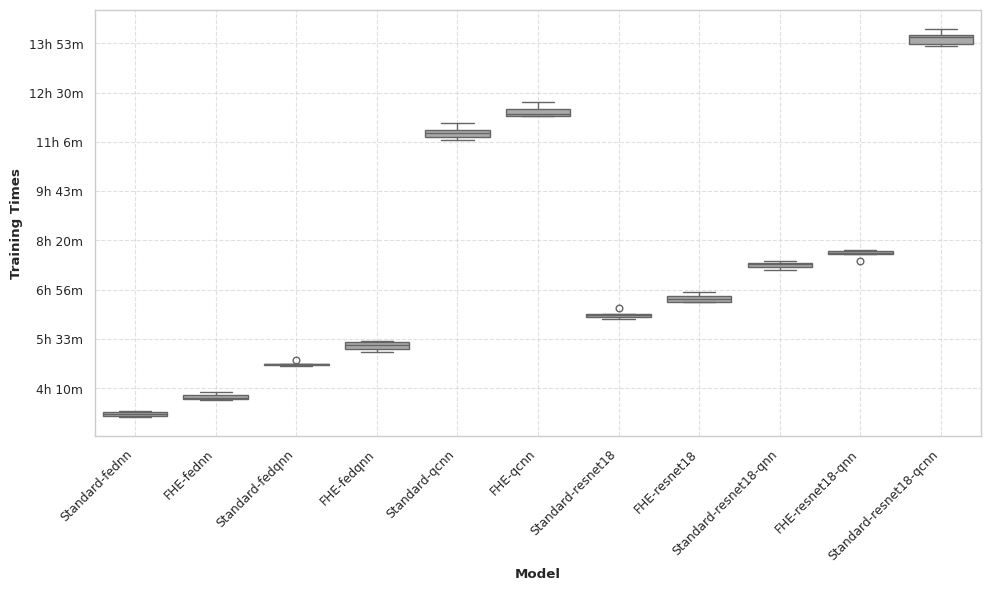

{
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Training Times', 'count')": 0.0833333333,
        "('Training Times', 'mean')": 206.3974139643,
        "('Training Times', 'std')": 4.1982447968,
        "('Training Times', 'min')": 201.791916724,
        "('Training Times', '25%')": 202.8619424542,
        "('Training Times', '50%')": 206.0593141039,
        "('Training Times', '75%')": 210.0331022223,
        "('Training Times', 'max')": 211.2407943169
    },
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Training Times', 'count')": 0.0833333333,
        "('Training Times', 'mean')": 235.9246222385,
        "('Training Times', 'std')": 5.4736597885,
        "('Training Times', 'min')": 230.6533737103,
        "('Training Times', '25%')": 232.0204767028,
        "('Training Times', '50%')": 234.1806450446,
        "('Training Times', '75%')": 238.7237062693,
        "('Training Times', 'max')": 244.0449094653
    },
    "7": {
        "('Model', '')": "S

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"


def display_boxplot(
    metrics_df: pd.DataFrame, metric_label: str, formatter: FuncFormatter = None
):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Model", y=metric_label, data=metrics_df, color=COLOR)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model", fontweight="bold")
    plt.ylabel(metric_label, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    if formatter:
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))
    # Display the plot
    plt.tight_layout()
    plt.show()


metric_label = "Training Times"
df = get_dataframe_from_metrics_data(training_times, metric_label)
display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)

stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

### Client Round Times

In [15]:
client_round_times = get_metric_by_model_type(
    runs, groups, "client_metric", "client_round_time"
)

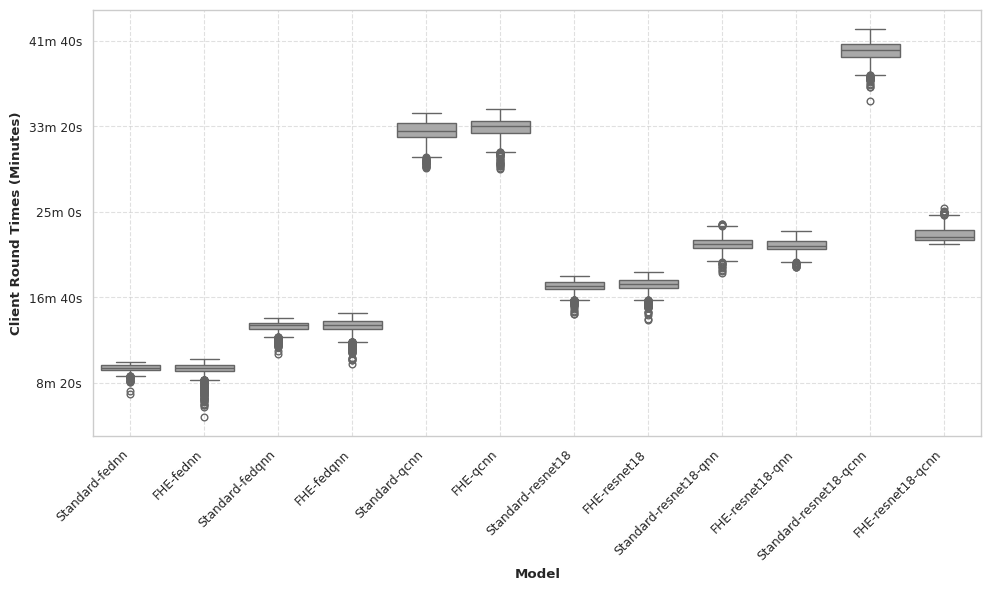

{
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Client Round Times (Minutes)', 'count')": 33.3333333333,
        "('Client Round Times (Minutes)', 'mean')": 9.6877705368,
        "('Client Round Times (Minutes)', 'std')": 0.6256600128,
        "('Client Round Times (Minutes)', 'min')": 5.0383253098,
        "('Client Round Times (Minutes)', '25%')": 9.4868919492,
        "('Client Round Times (Minutes)', '50%')": 9.7998285015,
        "('Client Round Times (Minutes)', '75%')": 10.0400071462,
        "('Client Round Times (Minutes)', 'max')": 10.6619777958
    },
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Client Round Times (Minutes)', 'count')": 33.3333333333,
        "('Client Round Times (Minutes)', 'mean')": 9.8181927068,
        "('Client Round Times (Minutes)', 'std')": 0.3006958271,
        "('Client Round Times (Minutes)', 'min')": 7.2207457622,
        "('Client Round Times (Minutes)', '25%')": 9.6441949497,
        "('Client Round Times (Min

In [16]:
metric_label = "Client Round Times (Minutes)"
df = get_dataframe_from_metrics_data(client_round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

### Server Round Times

In [17]:
round_times = get_metric_by_model_type(runs, groups, "server_metric", "round_time")

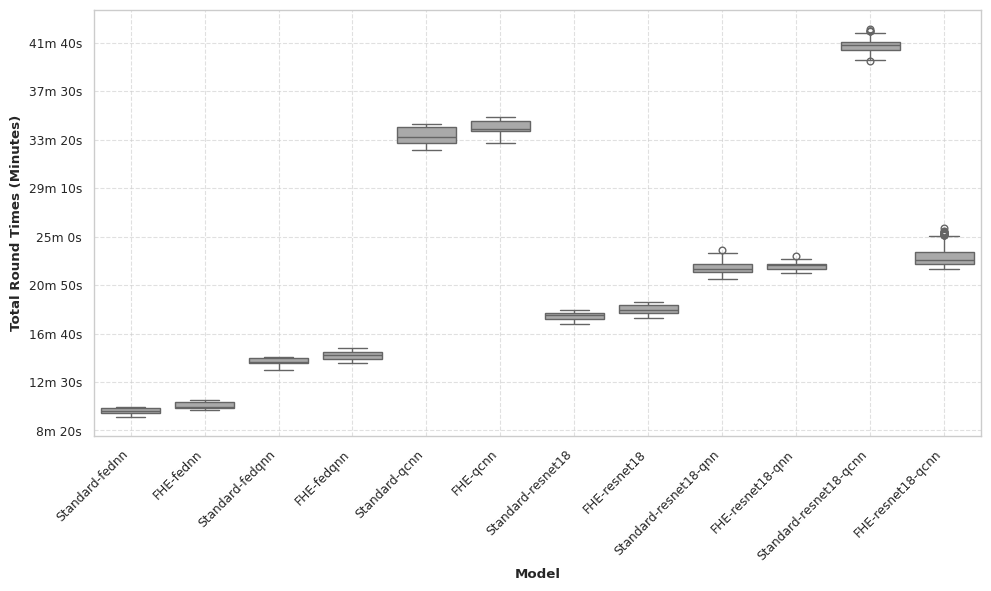

{
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Total Round Times (Minutes)', 'count')": 1.6666666667,
        "('Total Round Times (Minutes)', 'mean')": 10.0427934759,
        "('Total Round Times (Minutes)', 'std')": 0.2276208912,
        "('Total Round Times (Minutes)', 'min')": 9.5075271726,
        "('Total Round Times (Minutes)', '25%')": 9.8048080951,
        "('Total Round Times (Minutes)', '50%')": 10.0176887055,
        "('Total Round Times (Minutes)', '75%')": 10.2488149931,
        "('Total Round Times (Minutes)', 'max')": 10.3579532226
    },
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Total Round Times (Minutes)', 'count')": 1.6666666667,
        "('Total Round Times (Minutes)', 'mean')": 10.4641240091,
        "('Total Round Times (Minutes)', 'std')": 0.2507678464,
        "('Total Round Times (Minutes)', 'min')": 10.1223571777,
        "('Total Round Times (Minutes)', '25%')": 10.2808170348,
        "('Total Round Times (Minutes)', '50

In [18]:
metric_label = "Total Round Times (Minutes)"
df = get_dataframe_from_metrics_data(round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

## CPU Usage

In [19]:
client_cpu_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_cpu_percentage"
)

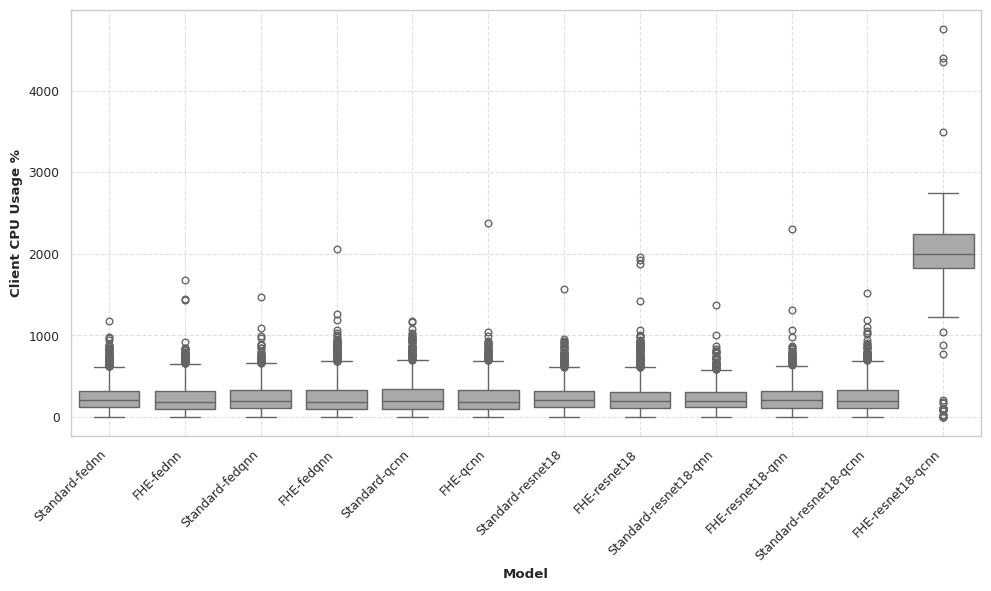

{
    "FHE-fednn": {
        "('Client CPU Usage %', 'count')": 2113.0,
        "('Client CPU Usage %', 'mean')": 226.5232371036,
        "('Client CPU Usage %', 'std')": 172.838645481,
        "('Client CPU Usage %', 'min')": 2.0,
        "('Client CPU Usage %', '25%')": 97.9,
        "('Client CPU Usage %', '50%')": 183.7,
        "('Client CPU Usage %', '75%')": 319.7,
        "('Client CPU Usage %', 'max')": 1683.8
    },
    "FHE-fedqnn": {
        "('Client CPU Usage %', 'count')": 2241.0,
        "('Client CPU Usage %', 'mean')": 240.2580990629,
        "('Client CPU Usage %', 'std')": 196.7641703641,
        "('Client CPU Usage %', 'min')": 2.0,
        "('Client CPU Usage %', '25%')": 97.9,
        "('Client CPU Usage %', '50%')": 187.8,
        "('Client CPU Usage %', '75%')": 331.7,
        "('Client CPU Usage %', 'max')": 2063.4
    },
    "FHE-qcnn": {
        "('Client CPU Usage %', 'count')": 2375.0,
        "('Client CPU Usage %', 'mean')": 236.0170526316,
        "('Cl

In [20]:
metric_label = "Client CPU Usage %"
df = get_dataframe_from_metrics_data(client_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

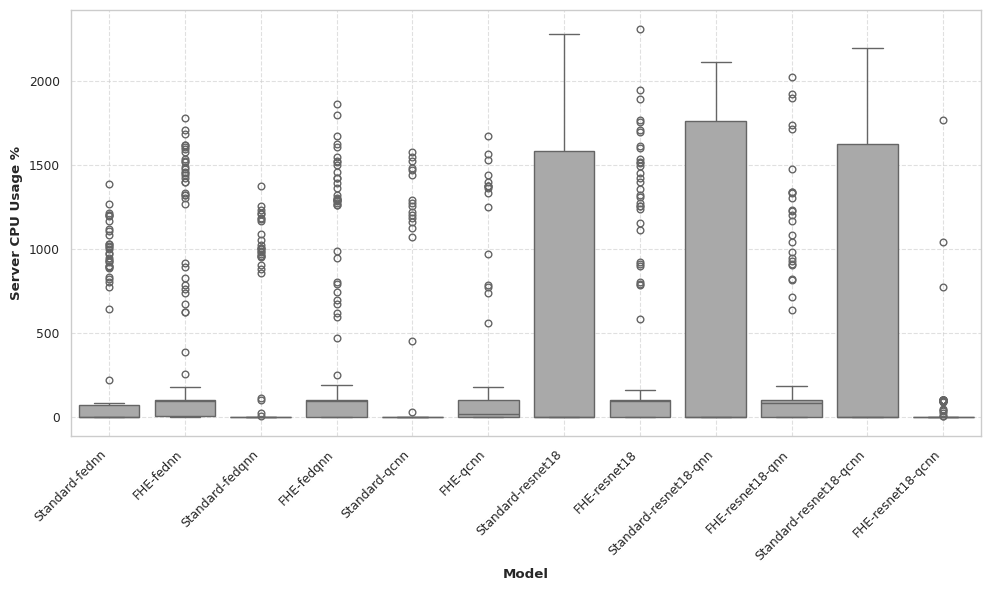

{
    "FHE-fednn": {
        "('Server CPU Usage %', 'count')": 428.0,
        "('Server CPU Usage %', 'mean')": 162.4177570093,
        "('Server CPU Usage %', 'std')": 345.3034086712,
        "('Server CPU Usage %', 'min')": 2.0,
        "('Server CPU Usage %', '25%')": 9.0,
        "('Server CPU Usage %', '50%')": 97.9,
        "('Server CPU Usage %', '75%')": 99.9,
        "('Server CPU Usage %', 'max')": 1782.3
    },
    "FHE-fedqnn": {
        "('Server CPU Usage %', 'count')": 393.0,
        "('Server CPU Usage %', 'mean')": 162.296692112,
        "('Server CPU Usage %', 'std')": 350.3858309418,
        "('Server CPU Usage %', 'min')": 2.0,
        "('Server CPU Usage %', '25%')": 2.0,
        "('Server CPU Usage %', '50%')": 97.9,
        "('Server CPU Usage %', '75%')": 99.9,
        "('Server CPU Usage %', 'max')": 1865.9
    },
    "FHE-qcnn": {
        "('Server CPU Usage %', 'count')": 220.0,
        "('Server CPU Usage %', 'mean')": 130.5672727273,
        "('Server CPU 

In [21]:
server_cpu_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_cpu_percentage"
)
metric_label = "Server CPU Usage %"
df = get_dataframe_from_metrics_data(server_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

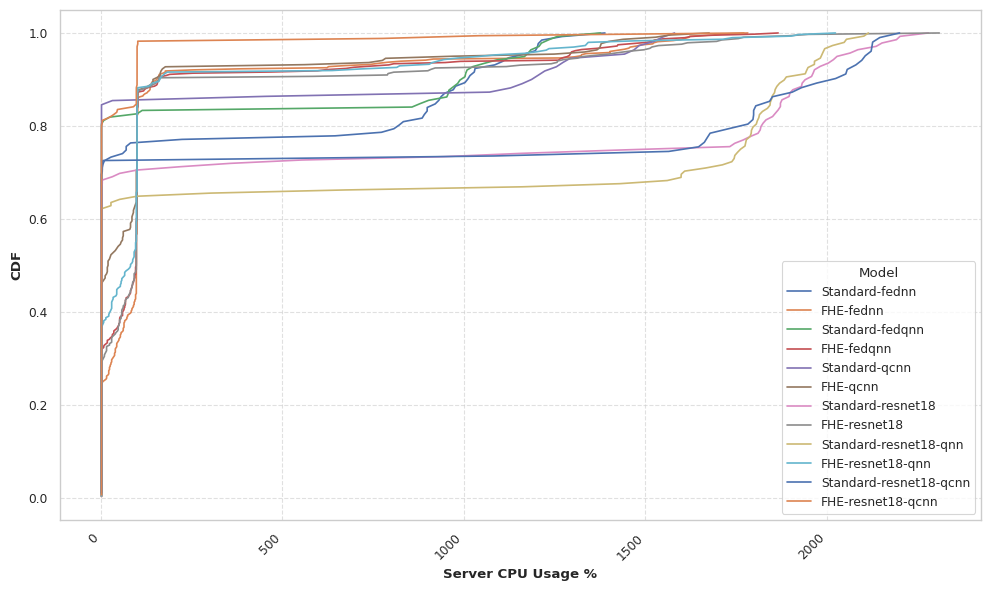

In [22]:
def display_cdf_plot(metrics_df: pd.DataFrame, metric_label: str):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))

    for model in metrics_df["Model"].unique():
        data = metrics_df[metrics_df["Model"] == model][metric_label]
        # Sort data for CDF calculation
        data_sorted = np.sort(data)
        cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        ax.plot(data_sorted, cdf, label=model)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel(metric_label, fontweight="bold")
    plt.ylabel("CDF", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    ax.legend(title="Model")

    # Display the plot
    plt.tight_layout()
    plt.show()


# Example usage:
display_cdf_plot(df, metric_label)

# RAM Usage

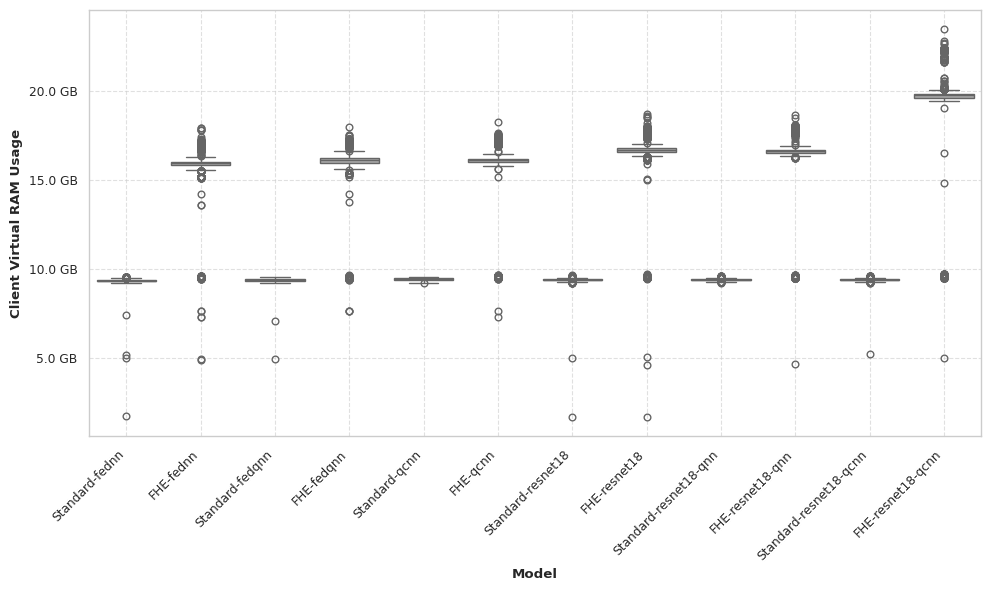

{
    "FHE-fednn": {
        "('Client Virtual RAM Usage', 'count')": 2441.0,
        "('Client Virtual RAM Usage', 'mean')": 15787.1213887751,
        "('Client Virtual RAM Usage', 'std')": 1356.3911704257,
        "('Client Virtual RAM Usage', 'min')": 4910.238,
        "('Client Virtual RAM Usage', '25%')": 15832.32,
        "('Client Virtual RAM Usage', '50%')": 15938.602,
        "('Client Virtual RAM Usage', '75%')": 16033.547,
        "('Client Virtual RAM Usage', 'max')": 17898.754
    },
    "FHE-fedqnn": {
        "('Client Virtual RAM Usage', 'count')": 2471.0,
        "('Client Virtual RAM Usage', 'mean')": 15892.8774475921,
        "('Client Virtual RAM Usage', 'std')": 1460.2623121386,
        "('Client Virtual RAM Usage', 'min')": 7635.359,
        "('Client Virtual RAM Usage', '25%')": 15978.195,
        "('Client Virtual RAM Usage', '50%')": 16129.988,
        "('Client Virtual RAM Usage', '75%')": 16236.777,
        "('Client Virtual RAM Usage', 'max')": 17949.273
   

In [23]:
def format_usage(usage_mb, _):
    if usage_mb < 1_000:
        return f"{int(usage_mb)} MB"
    else:
        gb = round(usage_mb / 1_000, 2)
        return f"{gb} GB"


client_vir_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_virtual_memory_mb"
)
metric_label = "Client Virtual RAM Usage"
df = get_dataframe_from_metrics_data(client_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

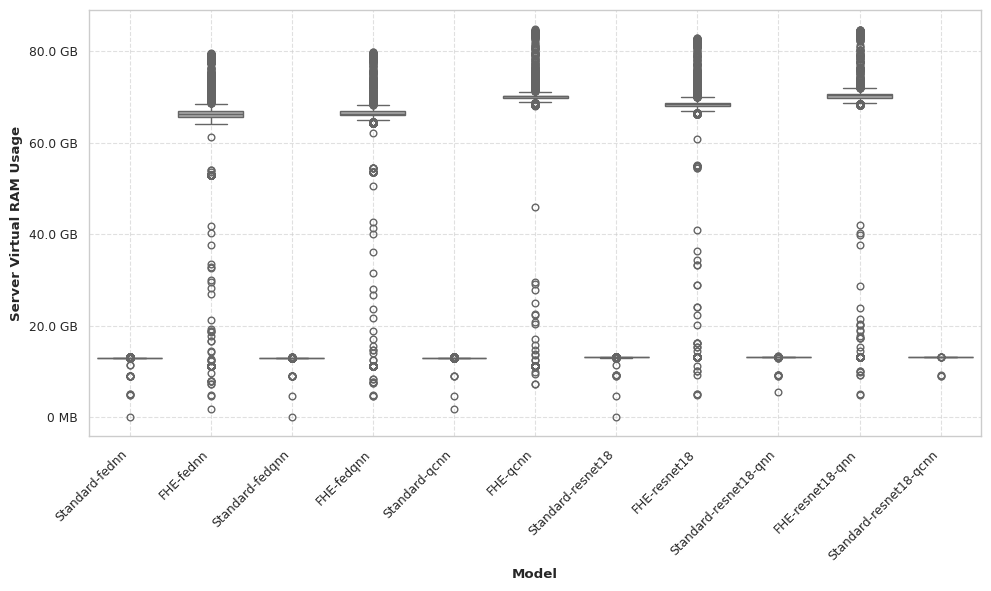

{
    "FHE-fednn": {
        "('Server Virtual RAM Usage', 'count')": 2436.0,
        "('Server Virtual RAM Usage', 'mean')": 64450.9947344007,
        "('Server Virtual RAM Usage', 'std')": 12763.4027408941,
        "('Server Virtual RAM Usage', 'min')": 1753.355,
        "('Server Virtual RAM Usage', '25%')": 65700.281,
        "('Server Virtual RAM Usage', '50%')": 66372.645,
        "('Server Virtual RAM Usage', '75%')": 66846.582,
        "('Server Virtual RAM Usage', 'max')": 79543.648
    },
    "FHE-fedqnn": {
        "('Server Virtual RAM Usage', 'count')": 2461.0,
        "('Server Virtual RAM Usage', 'mean')": 64953.2262633076,
        "('Server Virtual RAM Usage', 'std')": 11992.7102892509,
        "('Server Virtual RAM Usage', 'min')": 4610.117,
        "('Server Virtual RAM Usage', '25%')": 66091.039,
        "('Server Virtual RAM Usage', '50%')": 66329.539,
        "('Server Virtual RAM Usage', '75%')": 66964.25,
        "('Server Virtual RAM Usage', 'max')": 79900.5
   

In [24]:
server_vir_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_virtual_memory_mb"
)
metric_label = "Server Virtual RAM Usage"
df = get_dataframe_from_metrics_data(server_vir_ram_usage, metric_label)

display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

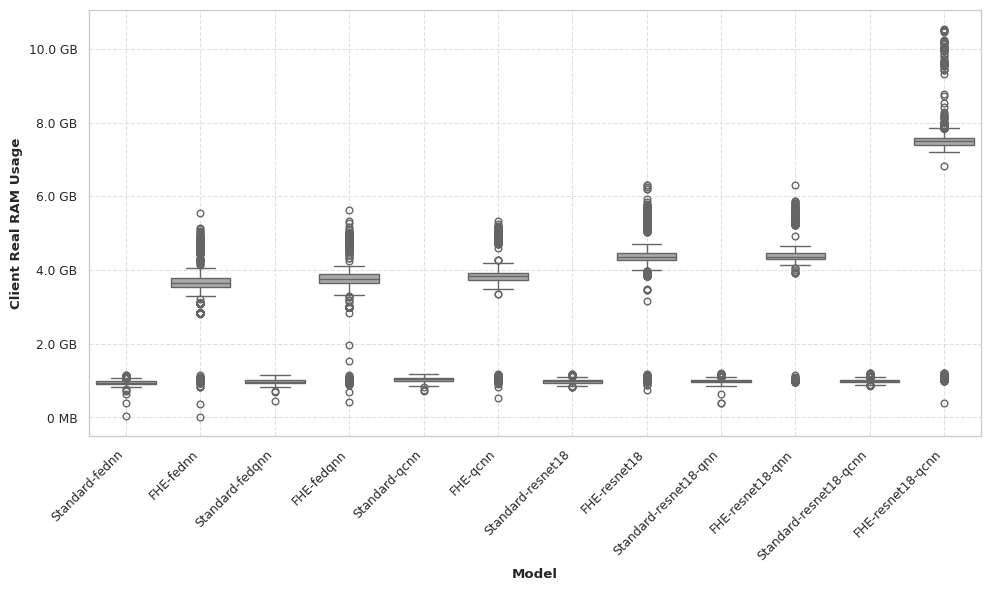

{
    "FHE-fednn": {
        "('Client Real RAM Usage', 'count')": 2454.0,
        "('Client Real RAM Usage', 'mean')": 3637.714995925,
        "('Client Real RAM Usage', 'std')": 694.8504508392,
        "('Client Real RAM Usage', 'min')": 13.5,
        "('Client Real RAM Usage', '25%')": 3544.492,
        "('Client Real RAM Usage', '50%')": 3651.6875,
        "('Client Real RAM Usage', '75%')": 3768.19375,
        "('Client Real RAM Usage', 'max')": 5535.023
    },
    "FHE-fedqnn": {
        "('Client Real RAM Usage', 'count')": 2470.0,
        "('Client Real RAM Usage', 'mean')": 3703.7927121457,
        "('Client Real RAM Usage', 'std')": 708.8240765599,
        "('Client Real RAM Usage', 'min')": 423.391,
        "('Client Real RAM Usage', '25%')": 3654.75525,
        "('Client Real RAM Usage', '50%')": 3765.203,
        "('Client Real RAM Usage', '75%')": 3879.168,
        "('Client Real RAM Usage', 'max')": 5631.605
    },
    "FHE-qcnn": {
        "('Client Real RAM Usage', 'co

In [25]:
client_real_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_real_memory_mb"
)
metric_label = "Client Real RAM Usage"
df = get_dataframe_from_metrics_data(client_real_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

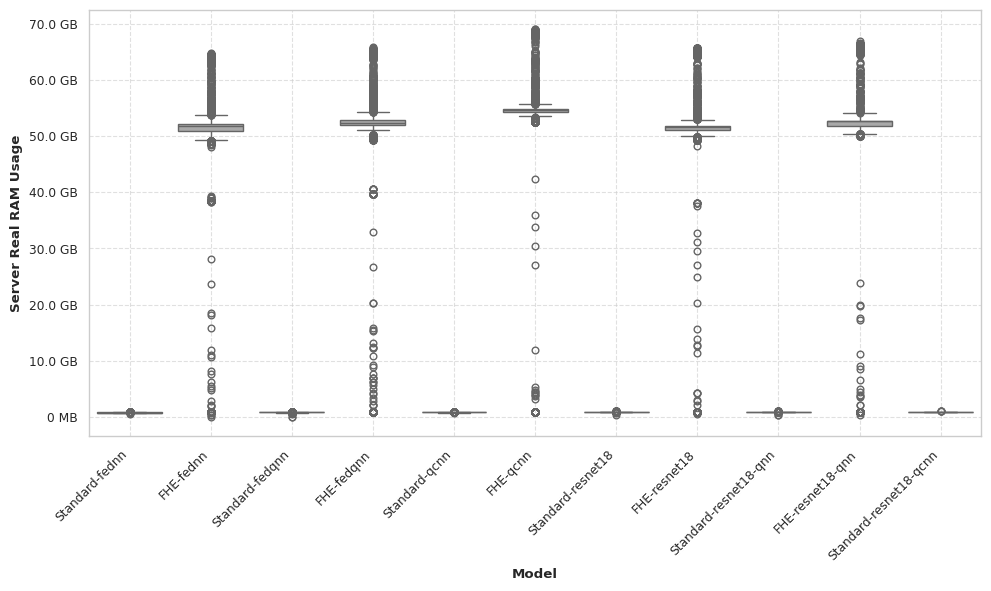

{
    "FHE-fednn": {
        "('Server Real RAM Usage', 'count')": 2438.0,
        "('Server Real RAM Usage', 'mean')": 50259.3458724364,
        "('Server Real RAM Usage', 'std')": 11652.910317182,
        "('Server Real RAM Usage', 'min')": 36.5,
        "('Server Real RAM Usage', '25%')": 50938.652,
        "('Server Real RAM Usage', '50%')": 51717.691,
        "('Server Real RAM Usage', '75%')": 52076.551,
        "('Server Real RAM Usage', 'max')": 64806.93
    },
    "FHE-fedqnn": {
        "('Server Real RAM Usage', 'count')": 2463.0,
        "('Server Real RAM Usage', 'mean')": 50896.5414660982,
        "('Server Real RAM Usage', 'std')": 11680.3814032996,
        "('Server Real RAM Usage', 'min')": 880.336,
        "('Server Real RAM Usage', '25%')": 52045.84,
        "('Server Real RAM Usage', '50%')": 52322.809,
        "('Server Real RAM Usage', '75%')": 52934.703,
        "('Server Real RAM Usage', 'max')": 65839.824
    },
    "FHE-qcnn": {
        "('Server Real RAM Usag

In [26]:
server_real_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_real_memory_mb"
)
metric_label = "Server Real RAM Usage"
df = get_dataframe_from_metrics_data(server_real_ram_usage, metric_label)
display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

# FHE

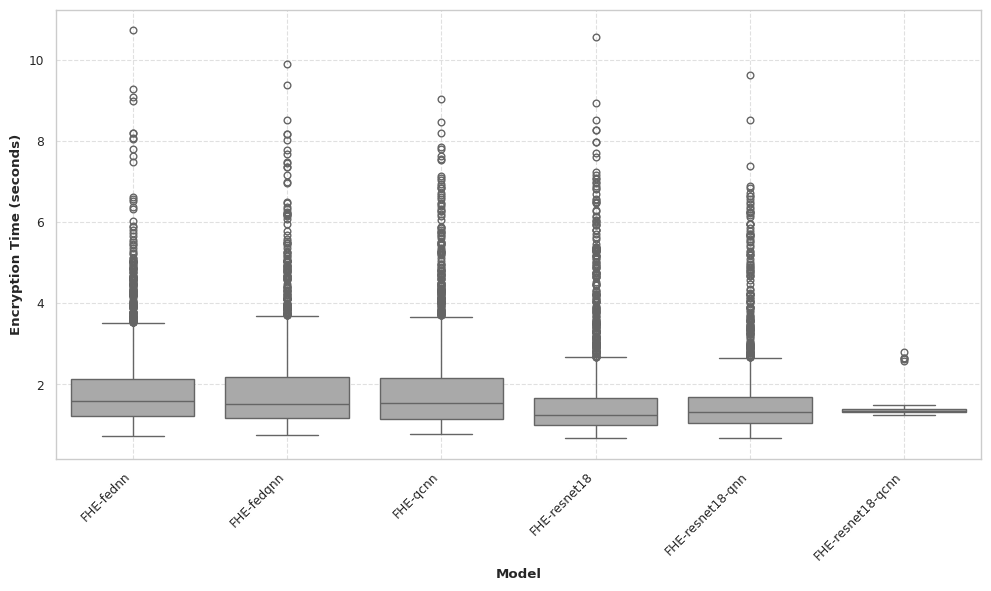

{
    "FHE-fednn": {
        "('Encryption Time (seconds)', 'count')": 2000.0,
        "('Encryption Time (seconds)', 'mean')": 1.8732074938,
        "('Encryption Time (seconds)', 'std')": 1.0531322246,
        "('Encryption Time (seconds)', 'min')": 0.7165923119,
        "('Encryption Time (seconds)', '25%')": 1.213804245,
        "('Encryption Time (seconds)', '50%')": 1.5932282209,
        "('Encryption Time (seconds)', '75%')": 2.1421750188,
        "('Encryption Time (seconds)', 'max')": 10.7331938744
    },
    "FHE-fedqnn": {
        "('Encryption Time (seconds)', 'count')": 2000.0,
        "('Encryption Time (seconds)', 'mean')": 1.8637973101,
        "('Encryption Time (seconds)', 'std')": 1.0875810257,
        "('Encryption Time (seconds)', 'min')": 0.7509920597,
        "('Encryption Time (seconds)', '25%')": 1.1699082851,
        "('Encryption Time (seconds)', '50%')": 1.52336061,
        "('Encryption Time (seconds)', '75%')": 2.1787727475,
        "('Encryption Time (sec

In [27]:
client_encryption_time = get_metric_by_model_type(
    runs, groups, "client_metric", "encryption_time"
)
metric_label = "Encryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

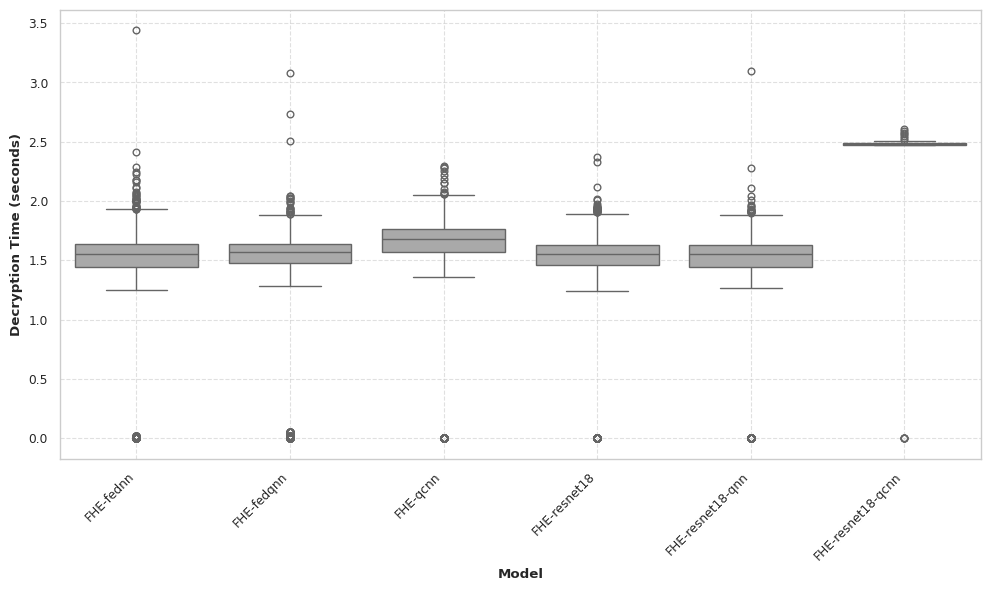

{
    "FHE-fednn": {
        "('Decryption Time (seconds)', 'count')": 2100.0,
        "('Decryption Time (seconds)', 'mean')": 1.4865961895,
        "('Decryption Time (seconds)', 'std')": 0.3636276542,
        "('Decryption Time (seconds)', 'min')": 0.000890255,
        "('Decryption Time (seconds)', '25%')": 1.4429298639,
        "('Decryption Time (seconds)', '50%')": 1.5523122549,
        "('Decryption Time (seconds)', '75%')": 1.6385290623,
        "('Decryption Time (seconds)', 'max')": 3.4397621155
    },
    "FHE-fedqnn": {
        "('Decryption Time (seconds)', 'count')": 2100.0,
        "('Decryption Time (seconds)', 'mean')": 1.4974709401,
        "('Decryption Time (seconds)', 'std')": 0.3550589327,
        "('Decryption Time (seconds)', 'min')": 0.0008351803,
        "('Decryption Time (seconds)', '25%')": 1.4777171612,
        "('Decryption Time (seconds)', '50%')": 1.5685616732,
        "('Decryption Time (seconds)', '75%')": 1.640781343,
        "('Decryption Time (sec

In [28]:
client_decryption_time = get_metric_by_model_type(
    runs, groups, "client_metric", "decryption_time"
)
metric_label = "Decryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_decryption_time, metric_label)

display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

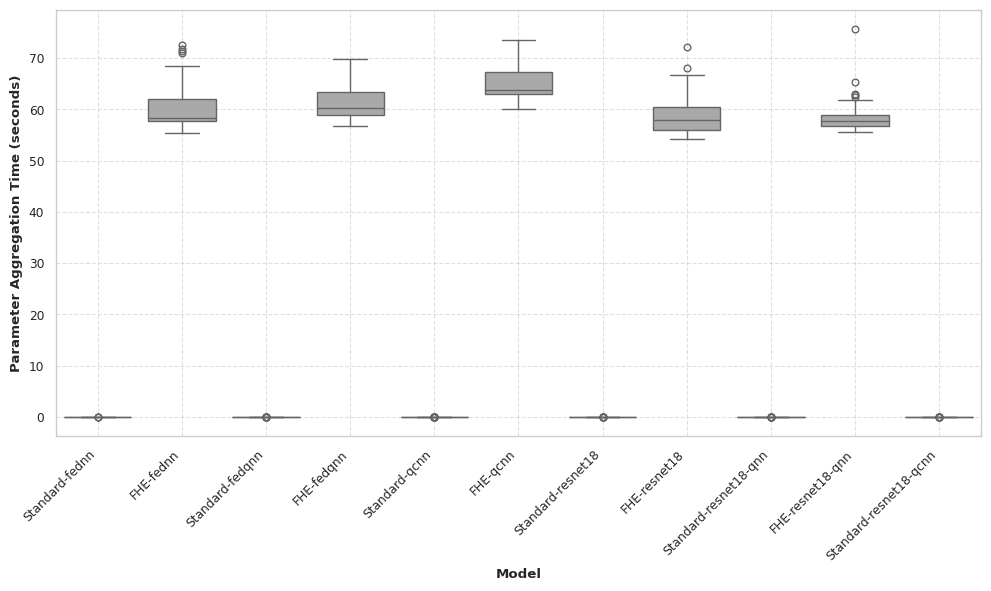

{
    "FHE-fednn": {
        "('Parameter Aggregation Time (seconds)', 'count')": 100.0,
        "('Parameter Aggregation Time (seconds)', 'mean')": 59.790676353,
        "('Parameter Aggregation Time (seconds)', 'std')": 3.6866565677,
        "('Parameter Aggregation Time (seconds)', 'min')": 55.427822113,
        "('Parameter Aggregation Time (seconds)', '25%')": 57.7014110088,
        "('Parameter Aggregation Time (seconds)', '50%')": 58.3568747044,
        "('Parameter Aggregation Time (seconds)', '75%')": 62.0786504149,
        "('Parameter Aggregation Time (seconds)', 'max')": 72.59516716
    },
    "FHE-fedqnn": {
        "('Parameter Aggregation Time (seconds)', 'count')": 100.0,
        "('Parameter Aggregation Time (seconds)', 'mean')": 61.1681371975,
        "('Parameter Aggregation Time (seconds)', 'std')": 3.0057458621,
        "('Parameter Aggregation Time (seconds)', 'min')": 56.8269331455,
        "('Parameter Aggregation Time (seconds)', '25%')": 58.9807604551,
       

In [29]:
server_aggregation_time = get_metric_by_model_type(
    runs, groups, "server_metric", "parameter_aggregation_time"
)
metric_label = "Parameter Aggregation Time (seconds)"
df = get_dataframe_from_metrics_data(server_aggregation_time, metric_label)

display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

# Communication Overhead

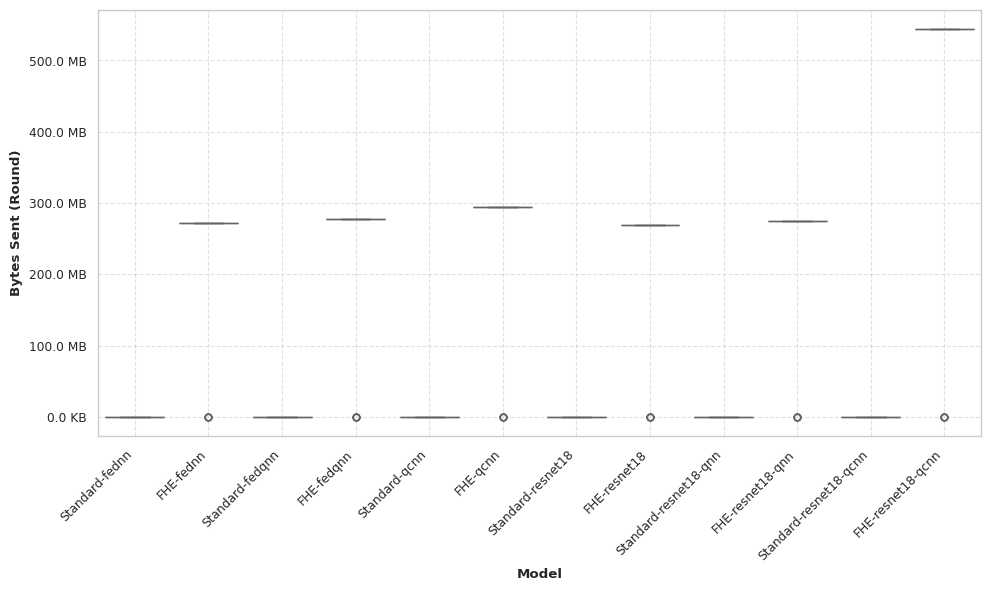

{
    "FHE-fednn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes Sent (Round)', 'mean')": 257764098.1,
        "('Bytes Sent (Round)', 'std')": 59430876.19839907,
        "('Bytes Sent (Round)', 'min')": 9435.0,
        "('Bytes Sent (Round)', '25%')": 271330133.0,
        "('Bytes Sent (Round)', '50%')": 271330133.0,
        "('Bytes Sent (Round)', '75%')": 271330133.0,
        "('Bytes Sent (Round)', 'max')": 271330133.0
    },
    "FHE-fedqnn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes Sent (Round)', 'mean')": 263248506.95,
        "('Bytes Sent (Round)', 'std')": 60695293.31232246,
        "('Bytes Sent (Round)', 'min')": 10004.0,
        "('Bytes Sent (Round)', '25%')": 277103165.0,
        "('Bytes Sent (Round)', '50%')": 277103165.0,
        "('Bytes Sent (Round)', '75%')": 277103165.0,
        "('Bytes Sent (Round)', 'max')": 277103165.0
    },
    "FHE-qcnn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes 

In [30]:
def format_bytes(bytes, _):
    if bytes < 1_000_000:
        value = round(int(bytes) * 0.001, 2)
        return f"{value} KB"
    if bytes < 1_000_000_000:
        value = round(int(bytes) * 0.000001, 2)
        return f"{value} MB"
    else:
        value = round(int(bytes) * 1e-9, 2)
        return f"{value} GB"


server_bytes_sent = get_metric_by_model_type(
    runs, groups, "server_metric", "Bytes Sent (Round)"
)
metric_label = "Bytes Sent (Round)"
df = get_dataframe_from_metrics_data(server_bytes_sent, metric_label)

display_boxplot(df, metric_label, format_bytes)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

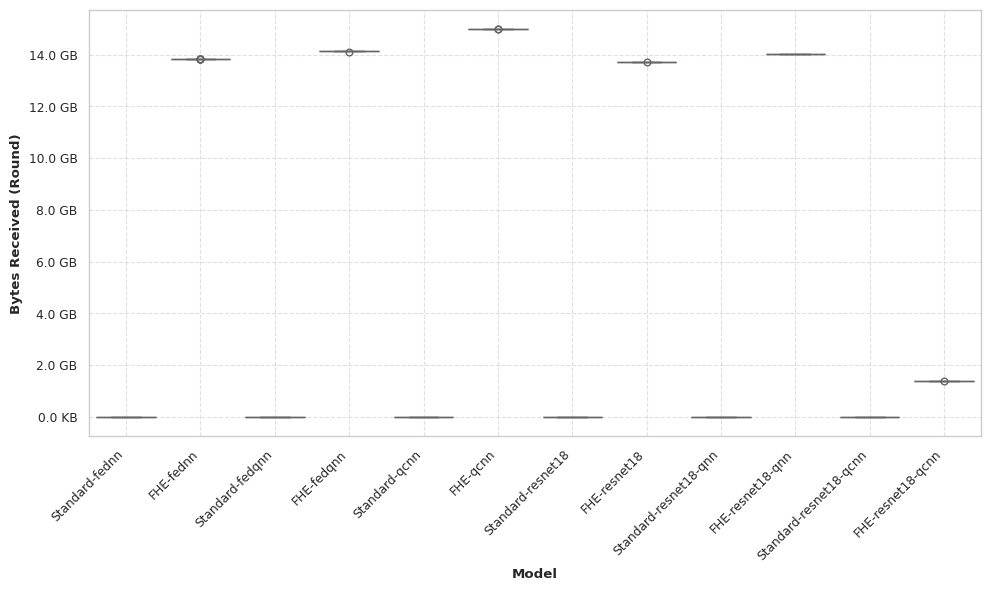

{
    "FHE-fednn": {
        "('Bytes Received (Round)', 'count')": 100.0,
        "('Bytes Received (Round)', 'mean')": 13825693600.09,
        "('Bytes Received (Round)', 'std')": 36938.0634330461,
        "('Bytes Received (Round)', 'min')": 13825584283.0,
        "('Bytes Received (Round)', '25%')": 13825674706.0,
        "('Bytes Received (Round)', '50%')": 13825692157.5,
        "('Bytes Received (Round)', '75%')": 13825713580.0,
        "('Bytes Received (Round)', 'max')": 13825775941.0
    },
    "FHE-fedqnn": {
        "('Bytes Received (Round)', 'count')": 100.0,
        "('Bytes Received (Round)', 'mean')": 14119859904.01,
        "('Bytes Received (Round)', 'std')": 38749.2133593651,
        "('Bytes Received (Round)', 'min')": 14119724356.0,
        "('Bytes Received (Round)', '25%')": 14119836086.25,
        "('Bytes Received (Round)', '50%')": 14119858948.0,
        "('Bytes Received (Round)', '75%')": 14119887373.25,
        "('Bytes Received (Round)', 'max')": 14119946

In [31]:
server_bytes_received = get_metric_by_model_type(
    runs, groups, "server_metric", "Bytes Received (Round)"
)
metric_label = "Bytes Received (Round)"
df = get_dataframe_from_metrics_data(server_bytes_received, metric_label)

display_boxplot(df, metric_label, format_bytes)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

In [32]:
server_total_bytes_sent = get_metric_by_model_type(
    runs, groups, "server_metric", "Total Bytes Sent"
)
metric_label = "Total Bytes Sent"
df = get_dataframe_from_metrics_data(server_total_bytes_sent, metric_label)

for model in KEY_ORDER:
    print(
        f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Sent"]), _)}"
    )

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

Standard-fednn: 188.7 KB
FHE-fednn: 5.16 GB
Standard-fedqnn: 200.08 KB
FHE-fedqnn: 5.26 GB
Standard-qcnn: 210.4 KB
FHE-qcnn: 5.59 GB
Standard-resnet18: 171.46 KB
FHE-resnet18: 5.12 GB
Standard-resnet18-qnn: 182.84 KB
FHE-resnet18-qnn: 5.23 GB
Standard-resnet18-qcnn: 346.76 KB
FHE-resnet18-qcnn: 10.33 GB
{
    "FHE-fednn": {
        "('Total Bytes Sent', 'count')": 100.0,
        "('Total Bytes Sent', 'mean')": 2577645698.5,
        "('Total Bytes Sent', 'std')": 1572447865.1420116,
        "('Total Bytes Sent', 'min')": 9435.0,
        "('Total Bytes Sent', '25%')": 1288827566.75,
        "('Total Bytes Sent', '50%')": 2577645698.5,
        "('Total Bytes Sent', '75%')": 3866463830.25,
        "('Total Bytes Sent', 'max')": 5155281962.0
    },
    "FHE-fedqnn": {
        "('Total Bytes Sent', 'count')": 100.0,
        "('Total Bytes Sent', 'mean')": 2632490071.5,
        "('Total Bytes Sent', 'std')": 1605904495.0541656,
        "('Total Bytes Sent', 'min')": 10004.0,
        "('Total 

In [33]:
server_total_bytes_received = get_metric_by_model_type(
    runs, groups, "server_metric", "Total Bytes Received"
)
metric_label = "Total Bytes Received"
df = get_dataframe_from_metrics_data(server_total_bytes_received, metric_label)

for model in KEY_ORDER:
    print(
        f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Received"]), _)}"
    )

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

Standard-fednn: 3.77 MB
FHE-fednn: 276.51 GB
Standard-fedqnn: 4.0 MB
FHE-fedqnn: 282.4 GB
Standard-qcnn: 4.21 MB
FHE-qcnn: 299.65 GB
Standard-resnet18: 3.43 MB
FHE-resnet18: 274.37 GB
Standard-resnet18-qnn: 3.66 MB
FHE-resnet18-qnn: 280.26 GB
Standard-resnet18-qcnn: 6.94 MB
FHE-resnet18-qcnn: 27.71 GB
{
    "FHE-fednn": {
        "('Total Bytes Received', 'count')": 100.0,
        "('Total Bytes Received', 'mean')": 145169769619.76,
        "('Total Bytes Received', 'std')": 80124471748.91966,
        "('Total Bytes Received', 'min')": 13825671356.0,
        "('Total Bytes Received', '25%')": 79497621595.75,
        "('Total Bytes Received', '50%')": 145169795034.5,
        "('Total Bytes Received', '75%')": 210841884320.5,
        "('Total Bytes Received', 'max')": 276514110474.0
    },
    "FHE-fedqnn": {
        "('Total Bytes Received', 'count')": 100.0,
        "('Total Bytes Received', 'mean')": 148258566765.98,
        "('Total Bytes Received', 'std')": 81829261716.34995,
      